### I. Open exploration

#### Importing packages

In [3]:
# Plotting tools
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

# Working with the data
import pandas as pd
import numpy as np

# Specific packages used in the code 
import time
import copy
import pprint
from __future__ import (unicode_literals, print_function, absolute_import, division)

# EMA packages
from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario)
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
from ema_workbench import save_results
from ema_workbench import load_results
ema_logging.log_to_stderr(ema_logging.INFO)

C:\Users\Mikhail\Anaconda3\lib\site-packages\ema_workbench\em_framework\optimization.py:29: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)


<Logger EMA (DEBUG)>

### 1. Specify the model: levers and outcomes

<b>Inputs</b> (levers, policies)

The model has 11 levers of 3 types. Let's discuss types first. You can do following:

1. __rise the dike__. 
2. implement the __room for the river project__. 
3. spend money on __evacuation__. 

The first two types of levers can be done on each 5 locations from A1 to A5, therefore you have 5 of them. The same applies for the room for the river project. The final lever is for all locations. So, overall you need to specify 11 outcomes.

<b>Outputs</b> (outcomes, objectives)

The model has 5 possible combinations of the outcomes. A combination of the outcomes called __"problem formulation"__. For example, you can look on the problem formulation number 0. It has only 2 outcomes of interest: expected number of deaths and total costs. Problem formulation number 1 has 3 outcomes of interest: expected number of deaths, expected annual damage and total investments costs. Please, check "problem_formulation.py" for more information. For the sake of demonstration, we will explore only problem formulation number 1 with 3 outcomes:
* expected number of deaths;
* expected annual damage;
* total investments costs.

__Uncertainties__

The model has __17 uncertainties__ of __5 types__. Let's discuss types first. There is uncertainty about:

1. Bmax 
2. pfail
3. Brate
4. discount rate
5. flood wave shape

The first 3 types of uncertainties can be found on each of 5 locations from A1 to A5, therefore in total you have 15 of them. The final two uncertainties are kind of "global" and correspond to the whole model.

- First that you need to do is to select the problem formulation (set of outcomes) that you want to explore by specifying the model. As was stated earlier you will study 3 objectives problem formulation (PF). To specify the model we created a function called "get_model_for_problem_formulation". You can find it in "problem_formulation.py". By writing dike_model = get_model_for_problem_formulation(1) with number 1 inside of the brackets you specified the model;

- Further, you need to specify levers. What do you want to do to tackle the problem of flooding? We created 4 policies (combination of levers) and name them.

In [4]:
# Specify the model (outcomes)
from problem_formulation import get_model_for_problem_formulation
dike_model = get_model_for_problem_formulation(1) # specify the model
n_objectives = 3 # number of objectives in chosen PF
n_uncertainties = 17

# Specify the policies (levers)
from specify import specify_levers
policy0 = Policy('policy_0', **specify_levers(0,0,0,0,0,0,0,0,0,0,0)) # DO NOTHING
policy1 = Policy('policy_1', **specify_levers(10,0,10,0,0,0,0,0,0,0,0)) # DO DIKES at A1, A3
policy2 = Policy('policy_2', **specify_levers(10,10,10,0,10,0,0,0,0,0,0)) # DO DIKES at A1, A2, A3, A5
policy3 = Policy('policy_3', **specify_levers(10,10,10,10,10,1,1,1,1,1,4)) # DO EVERYTHING
n_levers = 11 # number of levers available
n_policies = 4 # number of policies under investigation

C:\Users\Mikhail\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
[MainProcess/INFO] model initialized


In [5]:
# # Print inputs
# for i in range(n_levers) : 
#     print(dike_model.levers[i])

# # Print outputs
# for i in range(n_objectives) : 
#     print(dike_model.outcomes[i])

# # Print uncertainties
# for i in range(n_uncertainties) : 
#     print(dike_model.uncertainties[i])

### 2. Run experiments

Second step is to run experiments. This process is about sampling over uncertainties or levers. Let's study the effects of uncertainties on the outcomes on interest first.

In [53]:
n_scenarios = 100 # select a number of scenarios (runs) that you want study, the more the better
start = time.time()
with MultiprocessingEvaluator(dike_model) as evaluator: # run experiments with all cores available on your machine
    results = evaluator.perform_experiments(n_scenarios, [policy0, policy1, policy2, policy3]) # get results of applying 4 policies
end = time.time() 
print('Simulation time is ' + str(round((end - start)/60)) + ' mintues')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 100 scenarios * 4 policies * 1 model(s) = 400 experiments
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 120 cases completed
[MainProcess/INFO] 160 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 240 cases completed
[MainProcess/INFO] 280 cases completed
[MainProcess/INFO] 320 cases completed
[MainProcess/INFO] 360 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Simulation time is 2 mintues


#### Save / load results

Due to the speed of the algorithm it is better to save results for later usage. You run experiments, save results and then use it for various purposes. Especially it is relevant for 10k and more experiments.

In [75]:
# file_name = 'open_exploration_' + str(n_scenarios) + 'k_' + str(n_policies) + 'pol_' + str(n_objectives) + 'obj' + '.tar.gz'
# save_results(results, file_name)
# results = load_results(file_name)

In [6]:
results = load_results('open_exploration_10k_4pol_3obj.tar.gz')

[MainProcess/INFO] results loaded succesfully from C:\Users\Mikhail\Python projects\Model-based decision-making\final assignment\open_exploration_10k_4pol_3obj.tar.gz


### 3. Analyze results statistically 

We're also using so-called "exploratory data analysis". It can be quite useful and insightful to check basic statistics of obtained results. What is max value for expected number of deaths? How costly it can be to implement the safest solution?

In [7]:
experiments, outcomes = results
n_scenarios = len(experiments) / n_policies

In [8]:
# Basic statistics
pd.DataFrame(outcomes).describe()

,Expected Annual Damage,Total Investment Costs,Expected Number of Deaths
count,4.000000e+04,4.000000e+04,40000.000000
mean,1.940341e+08,3.122628e+08,0.217101
std,3.341941e+08,3.685595e+08,0.379878
min,0.000000e+00,0.000000e+00,0.000000
25%,2.440446e+05,7.467223e+07,0.000090
50%,3.584031e+07,1.559117e+08,0.023466
75%,2.176465e+08,3.935023e+08,0.243954
max,2.504875e+09,9.372439e+08,2.238539


In [9]:
# DO NOTHING policy
pd.DataFrame(outcomes).iloc[:int(n_scenarios),:].describe()

,Expected Annual Damage,Total Investment Costs,Expected Number of Deaths
count,1.000000e+04,10000.0,10000.000000
mean,6.117689e+08,0.0,0.709871
std,4.307234e+08,0.0,0.475356
min,8.089945e+06,0.0,0.011684
25%,2.332155e+08,0.0,0.288917
50%,5.590924e+08,0.0,0.665781
75%,8.970500e+08,0.0,1.042583
max,2.504875e+09,0.0,2.238539


In [10]:
# DO EVERYTHING policy
pd.DataFrame(outcomes).iloc[int(n_scenarios * (n_policies - 1)):int(n_scenarios * n_policies),:].describe()

,Expected Annual Damage,Total Investment Costs,Expected Number of Deaths
count,1.000000e+04,1.000000e+04,10000.000000
mean,1.202120e+05,9.372276e+08,0.000022
std,2.142665e+06,1.876204e+02,0.000586
min,0.000000e+00,9.372276e+08,0.000000
25%,0.000000e+00,9.372276e+08,0.000000
50%,0.000000e+00,9.372276e+08,0.000000
75%,0.000000e+00,9.372276e+08,0.000000
max,1.756389e+08,9.372439e+08,0.054895


###  4. Analyze success of the policies visually

Of course, pure numbers don't speak for themselves. Let's visualize results.

#### Heatmap for correlations

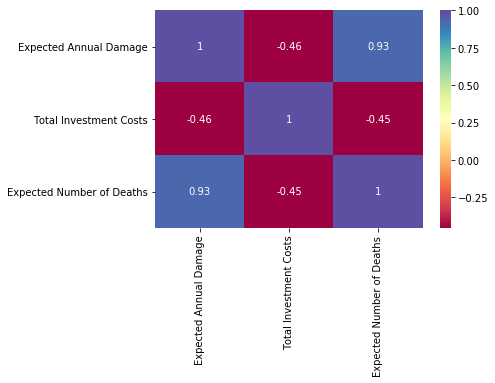

In [11]:
# Let's check correlations
sns.heatmap(pd.DataFrame(outcomes).corr(),annot=True, cmap= "Spectral")

#### Pairgrid

To plot a pair grid, we need to preprocess results. Basically, it is just adding a column with the number of the policy to obtained outcomes.

#### Preprocess results

In [12]:
experiments, outcomes = results
n_scenarios = len(experiments) / n_policies

policies = np.empty([len(experiments), 1])
k = 0
l = n_scenarios
for i in range (len(experiments)) : 
    policies[i] = k
    if (i == l - 1) : 
        k = k + 1
        l = l + n_scenarios
policies = policies.astype(int)

data = pd.DataFrame.from_dict(outcomes)
data['policy'] = policies

Now we can observe the real effects of having uncertainties involved! You can see that depending on the various combinations of uncertainties DO NOTHING policy can be quite dangerous (check the final set of graphs). The expected number of deaths here varies from 0 up to 2.2. Interestingly, the most secure policy DO EVERYTHING still has some variations in deaths and damage.

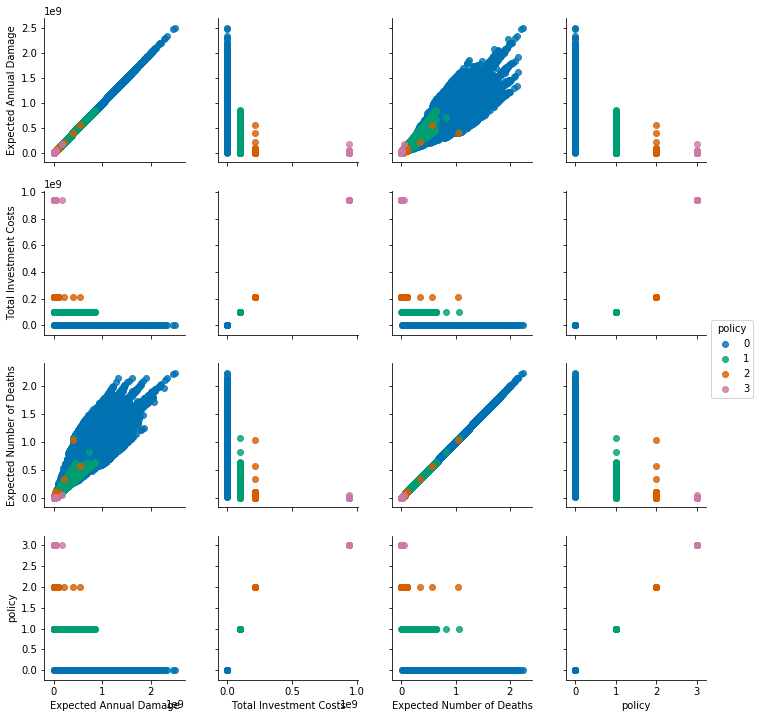

In [13]:
g = sns.PairGrid(data, hue='policy', palette='colorblind')
g.map(plt.scatter, alpha=0.8)
g.add_legend()

#### Tsplot

C:\Users\Mikhail\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
C:\Users\Mikhail\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
C:\Users\Mikhail\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
C:\Users\Mikhail\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


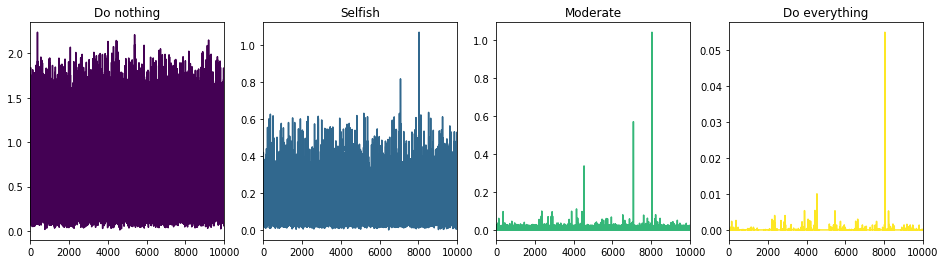

In [14]:
# Show ranges in Expected Number of Deaths
fig, axs = plt.subplots(figsize=[16,4],ncols=4)
colors = iter(cm.viridis(np.linspace(0, 1, 4)))
l = ['Do nothing', 'Selfish', 'Moderate', 'Do everything']
for i in range(0, n_policies) : 
    sns.tsplot(data=data[data.policy == int(i)]['Expected Number of Deaths'].reset_index(drop=True), ax=axs[i], legend=True, color=next(colors)).set_title(l[i])
    # plt.xlabel('experiments')
    # plt.ylabel('values')

C:\Users\Mikhail\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
C:\Users\Mikhail\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
C:\Users\Mikhail\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
C:\Users\Mikhail\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


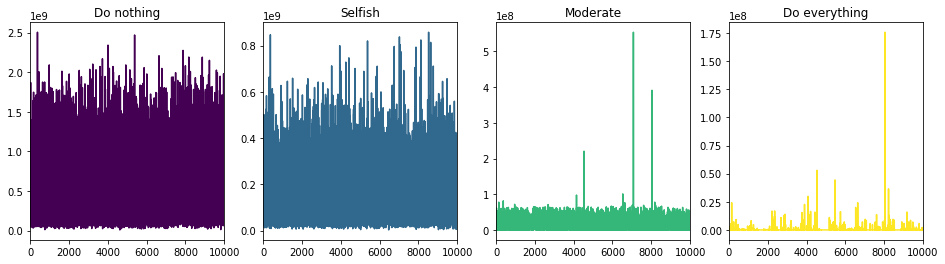

In [15]:
# Show ranges in Expected Annual Damage
fig, axs = plt.subplots(figsize=[16,4],ncols=4)
colors = iter(cm.viridis(np.linspace(0, 1, 4)))
l = ['Do nothing', 'Selfish', 'Moderate', 'Do everything']
for i in range(0, n_policies) : 
    sns.tsplot(data=data[data.policy == int(i)]['Expected Annual Damage'].reset_index(drop=True), ax=axs[i], legend=True, color=next(colors)).set_title(l[i])
    # plt.xlabel('experiments')
    # plt.ylabel('values')